In [ ]:
import os
import json
import numpy as np
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import cv2
import itertools

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize

import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torchvision.models import resnet50, efficientnet_b0, efficientnet_b2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold
from torchvision.transforms import ToPILImage
from skimage.feature import hog

from gradcam.utils import visualize_cam
from gradcam import GradCAM
from itertools import cycle

import lime
import lime.lime_tabular
from IPython.display import HTML, display

# Dataset Preparation

In [86]:
# Paths
root_path = os.path.join('..', 'dataset', 'malaria')
train_json_path = os.path.join(root_path, 'training.json')
test_json_path = os.path.join(root_path, 'test.json')
image_path = os.path.join(root_path, 'images')
print("Root Path:", root_path)
print("Train JSON Path:", train_json_path)
print("Test JSON Path:", test_json_path)
print("Image Path:", image_path)

Root Path: ..\dataset\malaria
Train JSON Path: ..\dataset\malaria\training.json
Test JSON Path: ..\dataset\malaria\test.json
Image Path: ..\dataset\malaria\images


In [ ]:
models_dir = os.path.join('.', 'resnet_models') # Directory to save models
os.makedirs(models_dir, exist_ok=True) # Create directory if it doesn't exist

print(f"Models will be saved in: {models_dir}")

Counting Images

In [ ]:
image_path = os.path.join('..', 'dataset', 'malaria', 'images')

# Check if the image directory exists
if not os.path.exists(image_path):
    print(f"Error: The image path '{image_path}' does not exist.")
else:
    # Use defaultdict to simplify counting
    image_sizes = defaultdict(int)
    
    # Get a list of all files in the directory
    image_files = os.listdir(image_path)
    
    # Iterate through the files and get the size of each image
    for filename in image_files:
        # Construct the full path to the image file
        full_path = os.path.join(image_path, filename)
        
        # Check if the file is a regular file and not a directory
        if os.path.isfile(full_path):
            try:
                # Open the image file using Pillow
                with Image.open(full_path) as img:
                    # Get the size (width, height) of the image
                    width, height = img.size
                    
                    # Increment the count for this specific size
                    image_sizes[(width, height)] += 1
            except Exception as e:
                # Handle cases where the file is not a valid image
                print(f"Could not open image file: {filename} - {e}")
    
    # Print the counts for each image size
    print("Image size counts:")
    for size, count in image_sizes.items():
        print(f"Size: {size[0]}x{size[1]}, Count: {count}")

Image size counts:
Size: 1600x1200, Count: 1208
Size: 1944x1383, Count: 120


Counting Json images

In [ ]:
# Function to count entries in a JSON file
def count_json_entries(file_path):
    if not os.path.exists(file_path):
        print(f"Error: The file path '{file_path}' does not exist.")
        return 0
    
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Assuming the JSON data is a list of entries
    return len(data)

# Count entries in each file
train_count = count_json_entries(train_json_path)
test_count = count_json_entries(test_json_path)

# Print the results
print(f"Number of entries in training.json: {train_count}")
print(f"Number of entries in test.json: {test_count}")

Number of entries in training.json: 1208
Number of entries in test.json: 120


Checking the structure of json 

In [ ]:
# Inspecting first two entries' structure and key fields
for i, entry in enumerate(train_data[:2]):
    print(f"\n--- Entry {i} keys:", list(entry.keys()))
    img_pathname = entry.get('image', {}).get('pathname')
    print(" image.pathname:", img_pathname)
    objs = entry.get('objects', [])
    print(" objects count:", len(objs))
    if objs:
        print(" first object keys:", list(objs[0].keys()))
        if 'bounding_box' in objs[0]:
            print(" bounding_box keys:", list(objs[0]['bounding_box'].keys()))

train_json_path: ..\dataset\malaria\training.json
image_path: ..\dataset\malaria\images
Loaded 1208 samples

--- Entry 0 keys: ['image', 'objects']
 image.pathname: /images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png
 objects count: 74
 first object keys: ['bounding_box', 'category']
 bounding_box keys: ['minimum', 'maximum']

--- Entry 1 keys: ['image', 'objects']
 image.pathname: /images/10be6380-cbbb-4886-8b9e-ff56b1710576.png
 objects count: 61
 first object keys: ['bounding_box', 'category']
 bounding_box keys: ['minimum', 'maximum']

Missing images count: 0


Visualizing data distribution

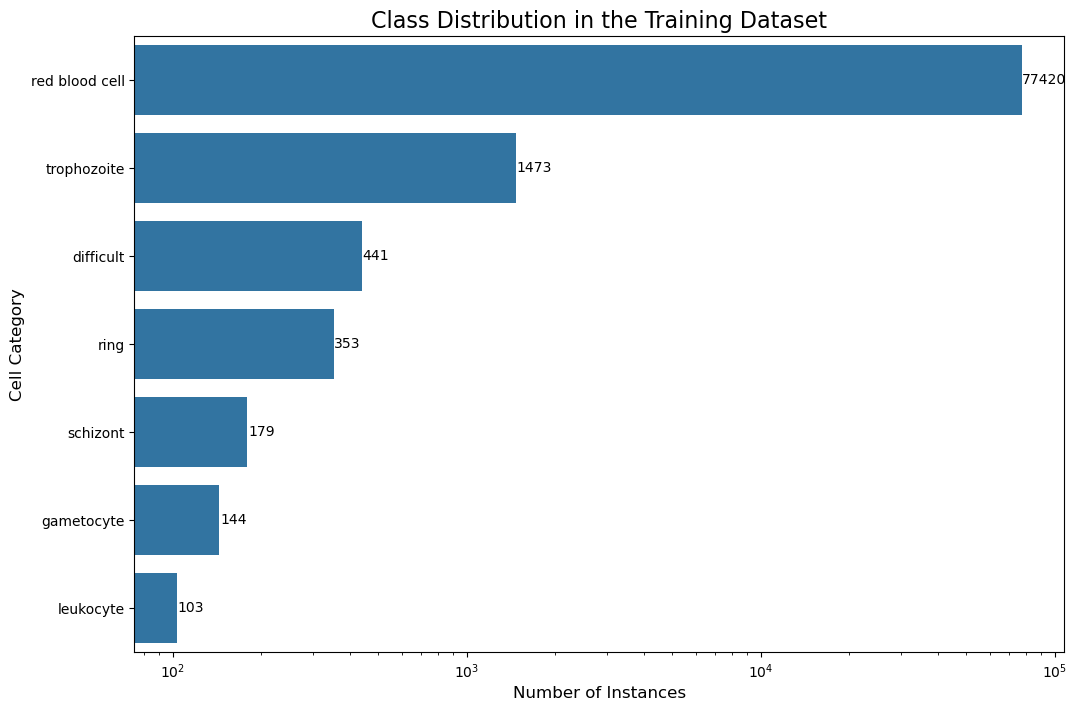

In [56]:
def ploting_cells_count(training_dataset_json):
  # Loading the JSON
  with open(training_dataset_json, 'r') as f:
      training_metadata = json.load(f)

  # Extracting all object categories into a list
  all_categories = []
  for item in training_metadata:
      for obj in item['objects']:
          all_categories.append(obj['category'])

  df = pd.DataFrame(all_categories, columns=['category'])

  # --- Plotting ---
  plt.figure(figsize=(12, 8))
  ax = sns.countplot(y='category', data=df, order=df['category'].value_counts().index)
  plt.title('Class Distribution in the Training Dataset', fontsize=16)
  plt.xlabel('Number of Instances', fontsize=12)
  plt.ylabel('Cell Category', fontsize=12)
  # Use a log scale for the x-axis due to the large imbalance
  plt.xscale('log')

  for p in ax.patches:
      width = p.get_width()
      y = p.get_y() + p.get_height() / 2

      # Adding the text to the plot
      ax.text(width + 1,  # Positioning the text slightly to the right of the bar
              y,
              f'{int(width)}', # Displaying count
              ha='left',      # Horizontal alignment
              va='center')    # Vertical alignment
  plt.show()

ploting_cells_count(train_json_path)

## B. Deeplearning

In [ ]:
class MalariaDataset(Dataset):
    def __init__(self, json_path, image_root, transform=None, category_map=None):
        with open(json_path, 'r') as f:
            self.entries = json.load(f)
        self.image_root = image_root
        self.transform = transform

        if category_map is None:
            all_categories = set()
            for item in self.entries:
                for obj in item['objects']:
                    all_categories.add(obj['category'])
            self.category_map = {cat: idx for idx, cat in enumerate(sorted(all_categories))}
        else:
            self.category_map = category_map
        
        # Store labels for each item, useful for sampling
        self.labels = []
        for item in self.entries:
            # We take the label of the first object for simplicity in sampling.
            # A more complex strategy could consider all objects.
            if item['objects']:
                cat = item['objects'][0]['category']
                self.labels.append(self.category_map[cat])
            else:
                # Handle images with no objects if necessary
                self.labels.append(-1) # Placeholder label

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        entry = self.entries[idx]
        pathname_from_json = entry['image']['pathname']
        image_name = os.path.basename(pathname_from_json)
        image_full_path = os.path.join(self.image_root, image_name)
        
        try:
            image = Image.open(image_full_path).convert("RGB")
        except FileNotFoundError:
            print(f"Error: Image not found at {image_full_path}")
            # Return a placeholder tensor if image is missing
            return torch.zeros((3, 128, 128)), {'boxes': torch.empty(0, 4), 'labels': torch.empty(0, dtype=torch.long)}

        boxes = []
        labels = []
        for obj in entry['objects']:
            bb = obj['bounding_box']
            boxes.append([bb['minimum']['c'], bb['minimum']['r'], bb['maximum']['c'], bb['maximum']['r']])
            labels.append(self.category_map[obj['category']])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        target = {'boxes': boxes, 'labels': labels}
        return image, target


In [ ]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


### Sampler

In [ ]:
# Utility function to create a sampler for handling class imbalance
def create_sampler(dataset):
    """Creates a WeightedRandomSampler to oversample minority classes."""
    # Count frequency of each class in the dataset
    class_counts = Counter(dataset.labels)
    
    # Remove placeholder labels if any
    if -1 in class_counts:
        del class_counts[-1]
        
    print("Class distribution:", class_counts)

    # Calculate weight for each class (more weight to rare classes)
    num_samples = len(dataset.labels)
    class_weights = {cls: num_samples / count for cls, count in class_counts.items()}
    
    # Assign a weight to each sample in the dataset
    sample_weights = [class_weights.get(label, 0) for label in dataset.labels]

    # Create the sampler
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    return sampler


### 1. Resnet50

In [ ]:
class ResNetDetector(nn.Module):
    # Your ResNetDetector class here...
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = resnet50(weights='IMAGENET1K_V1')
        # Replace the final fully connected layer
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity() # Remove the original classifier

        # New heads for your task
        self.classifier = nn.Linear(num_features, num_classes)
        self.bbox_head = nn.Linear(num_features, 4)

    def forward(self, x):
        features = self.backbone(x)
        class_scores = self.classifier(features)
        bbox_preds = self.bbox_head(features)
        return class_scores, bbox_preds


In [ ]:
# Your loss functions and collate_fn here...
def margin_loss(class_scores, targets, margin=0.2):
    one_hot_targets = F.one_hot(targets.long(), num_classes=class_scores.size(-1)).float()
    left = F.relu(margin - class_scores) * one_hot_targets
    right = F.relu(class_scores - (1 - margin)) * (1.0 - one_hot_targets)
    return (left + right).sum(dim=-1).mean()

def bbox_loss(preds, targets):
    if preds.dim() == 1:
        preds = preds.unsqueeze(0)
    num_preds, num_targets = preds.size(0), targets.size(0)
    if num_preds > num_targets:
        padding = torch.zeros((num_preds - num_targets, 4), device=targets.device)
        targets = torch.cat([targets, padding], dim=0)
    elif num_targets > num_preds:
        padding = torch.zeros((num_targets - num_preds, 4), device=preds.device)
        preds = torch.cat([preds, padding], dim=0)
    return F.smooth_l1_loss(preds, targets)

def custom_collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    images = torch.stack(images, dim=0)
    return images, targets


Epoch 1/3


Training Epoch 1: 100%|██████████| 38/38 [04:19<00:00,  6.82s/batch, loss=11.9]


Train Epoch: 1, Loss: 16.3383, Accuracy: 84.83%


Validating: 100%|██████████| 4/4 [00:14<00:00,  3.63s/batch, loss=18.6]


Validation Loss: 23.1370, Accuracy: 66.94%
Epoch 2/3


Training Epoch 2: 100%|██████████| 38/38 [03:56<00:00,  6.24s/batch, loss=12]  


Train Epoch: 2, Loss: 15.8280, Accuracy: 78.00%


Validating: 100%|██████████| 4/4 [00:10<00:00,  2.65s/batch, loss=17.7]


Validation Loss: 21.0275, Accuracy: 20.60%
Epoch 3/3


Training Epoch 3: 100%|██████████| 38/38 [03:46<00:00,  5.96s/batch, loss=11.8]


Train Epoch: 3, Loss: 15.7335, Accuracy: 64.86%


Validating: 100%|██████████| 4/4 [00:10<00:00,  2.62s/batch, loss=15.4]


Validation Loss: 19.6321, Accuracy: 11.65%


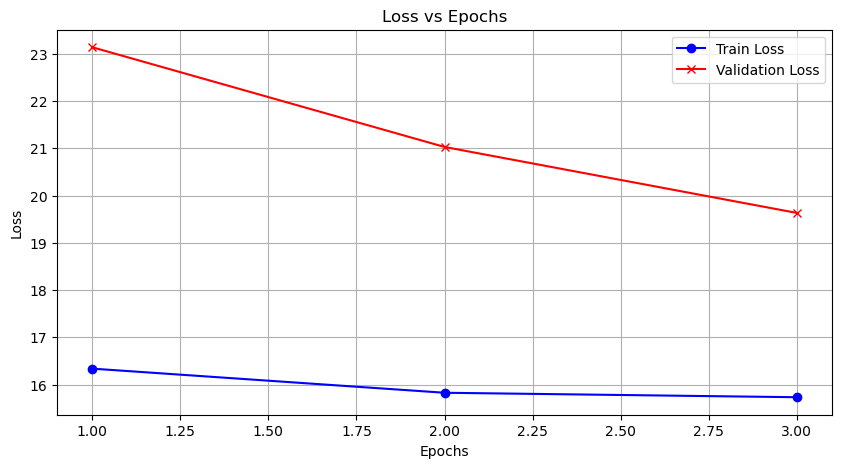

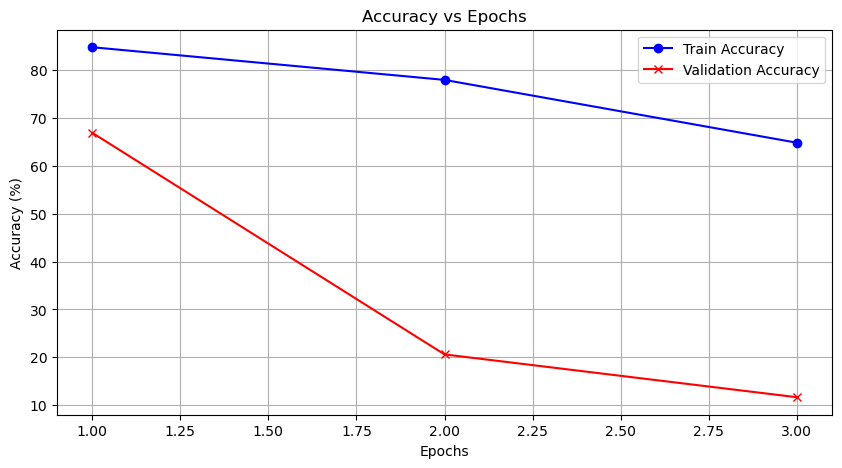

In [ ]:
# Your train and validate functions here...
def train_model(model, train_loader, optimizer, epoch, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(train_loader, desc=f"Training Epoch {epoch}", unit="batch")
    for images, targets_list in pbar:
        images = images.to(device)
        optimizer.zero_grad()

        class_scores, bbox_preds = model(images)
        
        batch_class_loss = 0
        batch_bbox_loss = 0
        
        for i in range(images.size(0)):
            target = targets_list[i]
            target_boxes = target['boxes'].to(device)
            target_labels = target['labels'].to(device)
            
            if len(target_labels) == 0: continue
            
            # Normalize bounding boxes
            target_boxes_norm = target_boxes / torch.tensor([128.0, 128.0, 128.0, 128.0], device=device)

            batch_class_loss += margin_loss(class_scores[i].unsqueeze(0), target_labels)
            batch_bbox_loss += bbox_loss(bbox_preds[i], target_boxes_norm)

            predicted = torch.argmax(class_scores[i])
            correct += (predicted == target_labels).sum().item()
            total += len(target_labels)
        
        loss = batch_class_loss + 0.1 * batch_bbox_loss
        if total > 0:
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total if total > 0 else 0
    print(f"Train Epoch: {epoch}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return epoch_loss, accuracy

def validate_model(model, val_loader, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, targets_list in tqdm(val_loader, desc="Validating", unit="batch"):
            images = images.to(device)
            class_scores, bbox_preds = model(images)

            for i in range(images.size(0)):
                target = targets_list[i]
                target_boxes = target['boxes'].to(device)
                target_labels = target['labels'].to(device)
                
                if len(target_labels) == 0: continue
                
                target_boxes_norm = target_boxes / torch.tensor([128.0, 128.0, 128.0, 128.0], device=device)

                loss = margin_loss(class_scores[i].unsqueeze(0), target_labels) + \
                       0.1 * bbox_loss(bbox_preds[i], target_boxes_norm)
                running_loss += loss.item()
                
                predicted = torch.argmax(class_scores[i])
                correct += (predicted == target_labels).sum().item()
                total += len(target_labels)

    epoch_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total if total > 0 else 0
    print(f"Validation Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return epoch_loss, accuracy



In [ ]:
def run_experiment(params):
    """
    Runs a full training and validation experiment for a given set of hyperparameters.
    """
    print("\n" + "="*50)
    print(f"STARTING EXPERIMENT with params: {params}")
    print("="*50)

    # --- 1. Setup Device and Datasets ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_ds = MalariaDataset(train_json_path, image_path, transform=train_transform)
    test_ds = MalariaDataset(test_json_path, image_path, transform=test_transform, category_map=train_ds.category_map)

    # --- 2. Create DataLoaders with optional sampling ---
    sampler = None
    shuffle = True
    if params['sampling'] == 'oversample':
        print("Applying weighted oversampling...")
        sampler = create_sampler(train_ds)
        shuffle = False # Sampler and shuffle are mutually exclusive

    train_loader = DataLoader(
        train_ds, 
        batch_size=params['batch_size'], 
        shuffle=shuffle, 
        sampler=sampler,
        collate_fn=custom_collate_fn,
        num_workers=2
    )
    val_loader = DataLoader(
        test_ds, 
        batch_size=params['batch_size'], 
        shuffle=False, 
        collate_fn=custom_collate_fn,
        num_workers=2
    )

    # --- 3. Initialize Model and Optimizer ---
    model = ResNetDetector(num_classes=len(train_ds.category_map)).to(device)
    
    if params['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    elif params['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9)
    else:
        raise ValueError("Unsupported optimizer type")
        
    # --- 4. Training Loop ---
    best_val_accuracy = 0.0
    num_epochs = 10 # You can increase this
    
    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = train_model(model, train_loader, optimizer, epoch, device)
        val_loss, val_accuracy = validate_model(model, val_loader, device)

        # Check if this is the best model so far
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            print(f"🎉 New best model found! Val Accuracy: {best_val_accuracy:.2f}%")
            
            # --- 5. Save the best model for this experiment ---
            model_filename = f"model_lr_{params['lr']}_optim_{params['optimizer']}_sampling_{params['sampling']}.pth"
            save_path = os.path.join(models_dir, model_filename)

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_accuracy': best_val_accuracy,
                'category_map': train_ds.category_map,
                'params': params
            }, save_path)
            print(f"Model saved to {save_path}")

    print(f"Finished experiment. Best validation accuracy: {best_val_accuracy:.2f}%")
    return best_val_accuracy

In [ ]:

if __name__ == '__main__':
    # Define the grid of hyperparameters to search
    param_grid = {
        'lr': [0.001, 0.0001],
        'optimizer': ['Adam', 'SGD'],
        'batch_size': [32],
        'sampling': ['none', 'oversample'] # 'none' for no sampling, 'oversample' for weighted sampling
    }

    # Generate all combinations of parameters
    keys, values = zip(*param_grid.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    results = []
    
    print(f"Starting Grid Search with {len(experiments)} experiments...")

    # Run each experiment
    for i, params in enumerate(experiments):
        print(f"\n--- Running Experiment {i+1}/{len(experiments)} ---")
        best_acc = run_experiment(params)
        results.append({'params': params, 'best_accuracy': best_acc})

    # --- Print final results ---
    print("\n\n" + "#"*30)
    print("GRID SEARCH COMPLETE")
    print("#"*30)
    
    # Sort results by accuracy
    sorted_results = sorted(results, key=lambda x: x['best_accuracy'], reverse=True)
    
    for result in sorted_results:
        print(f"Accuracy: {result['best_accuracy']:.2f}% | Params: {result['params']}")

    print(f"\nBest configuration found: {sorted_results[0]}")


In [ ]:
# def visualize_prediction(model, dataset, device, category_map, threshold=0.5):
#     model.eval()  

#     idx = random.randint(0, len(dataset) - 1)
#     image, target = dataset[idx]

#     image = image.to(device).unsqueeze(0)  

#     with torch.no_grad():
#         class_scores, bbox_preds = model(image)

#     to_pil = ToPILImage()
#     image = to_pil(image.squeeze(0).cpu())

#     bbox_preds = bbox_preds.squeeze(0).cpu()
#     class_scores = class_scores.squeeze(0).cpu()

#     if bbox_preds.ndim == 1:
#         bbox_preds = bbox_preds.unsqueeze(0)  

#     if class_scores.ndim == 1:
#         class_scores = class_scores.unsqueeze(0) 

#     if bbox_preds.size(0) != class_scores.size(0):
#         raise ValueError(f"Mismatch between number of predicted boxes ({bbox_preds.size(0)}) and class scores ({class_scores.size(0)}).")

#     selected_boxes = []
#     selected_labels = []
#     for i, score in enumerate(class_scores):
#         if score.max() > threshold: 
#             selected_boxes.append(bbox_preds[i].tolist())
#             selected_labels.append(score.argmax().item())

#     plt.figure(figsize=(10, 10))
#     plt.imshow(image)
#     ax = plt.gca()

#     for box, label in zip(selected_boxes, selected_labels):
#         x_min, y_min, x_max, y_max = box
#         width, height = x_max - x_min, y_max - y_min

#         rect = plt.Rectangle((x_min, y_min), width, height,
#                              fill=False, color='red', linewidth=2)
#         ax.add_patch(rect)

#         if label in category_map:
#             label_text = category_map[label]
#         else:
#             label_text = f"Unknown ({label})"  

#         ax.text(x_min, y_min - 5, label_text, color='red', fontsize=12, backgroundcolor='white')

#     plt.axis('off')
#     plt.title("Predictions with Bounding Boxes and Labels")
#     plt.show()

# Explainable AI
<ol>
<li>Gradcam
<li>Shap
<li>lime 
<li>Class Mapping
</ol>

gradcam for resnet

In [ ]:
# Add this to a new cell to inspect your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetDetector(num_classes=len(train_ds.category_map)).to(device)
print(model)

ResNetDetector(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
# Denormalize image for visualization (same as before)
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor
#
# ... (all your imports should be here) ...
#

def visualize_gradcam(model, target_layer, image_tensor, target_category=None): # CORRECTED: Added target_layer as an argument
    """
    Generates and displays a Grad-CAM visualization.
    (Accepts the model and target_layer separately)
    """
    # 1. Setup Grad-CAM
    # The target_layer is now passed in directly
    cam = GradCAM(model, target_layer)
    
    # 2. Prepare the image for the model
    image_for_model = image_tensor.to(device).unsqueeze(0)
    
    # Use the predicted class if no target is specified
    if target_category is None:
        model.eval()
        # The wrapped model only returns scores
        class_scores = model(image_for_model)
        target_category = class_scores.argmax(dim=1).item()
    else:
         class_scores = model(image_for_model)


    # 3. Generate the heatmap
    mask, _ = cam(image_for_model, target_category)
    
    heatmap, result = visualize_cam(mask, image_tensor)
    
    # 4. Display the results
    pil_image = to_pil_image(denormalize(image_tensor.clone()))
    heatmap_pil = to_pil_image(heatmap)
    result_pil = to_pil_image(result)
    
    inv_category_map = {v: k for k, v in train_ds.category_map.items()}
    model.eval()
    predicted_class = model(image_for_model).argmax(dim=1).item()
    predicted_label = inv_category_map.get(predicted_class, "Unknown")
    target_label = inv_category_map.get(target_category, "Unknown")
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(pil_image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(heatmap_pil)
    axs[1].set_title('Grad-CAM Heatmap')
    axs[1].axis('off')

    axs[2].imshow(result_pil)
    axs[2].set_title(f'Result (Predicted: {predicted_label})')
    axs[2].axis('off')
    
    plt.suptitle(f"Explanation for class: {target_label}", fontsize=16)
    plt.show()

C:\Users\shera\AppData\Local\Temp\ipykernel_2916\1983813145.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_model.load_state_dict(torch.load(model_path, map_loc

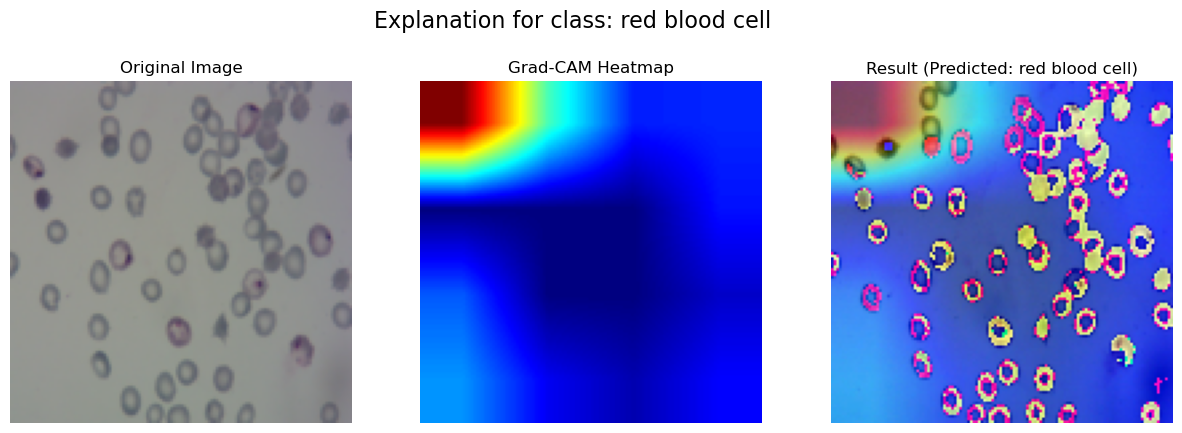

In [ ]:
# Load your best trained ResNet model (as before)
model_path = "resnet_model_epoch_10.pth"
original_model = ResNetDetector(num_classes=len(train_ds.category_map))
original_model.load_state_dict(torch.load(model_path, map_location=device))
original_model.to(device)

# Create the wrapper for the forward pass (as before)
class GradCAMModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        class_scores, _ = self.model(x)
        return class_scores

gradcam_model = GradCAMModelWrapper(original_model)

# CORRECTED: Define the target layer from the ORIGINAL model
target_layer = original_model.backbone.layer4[-1]

# Get a sample image (as before)
test_ds_vis = MalariaDataset(test_json_path, image_path, transform=test_transform, category_map=train_ds.category_map)
image, target = test_ds_vis[15]

# CORRECTED: Call the function with the new signature
visualize_gradcam(gradcam_model, target_layer, image, target_category=target['labels'][0].item())

gradcam of effnet 

In [ ]:
# You can run this in a cell to see the architecture
effnet_b0_temp = EfficientNetDetector('b0', num_classes=len(train_ds.category_map))
print(effnet_b0_temp)

EfficientNetDetector(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNor

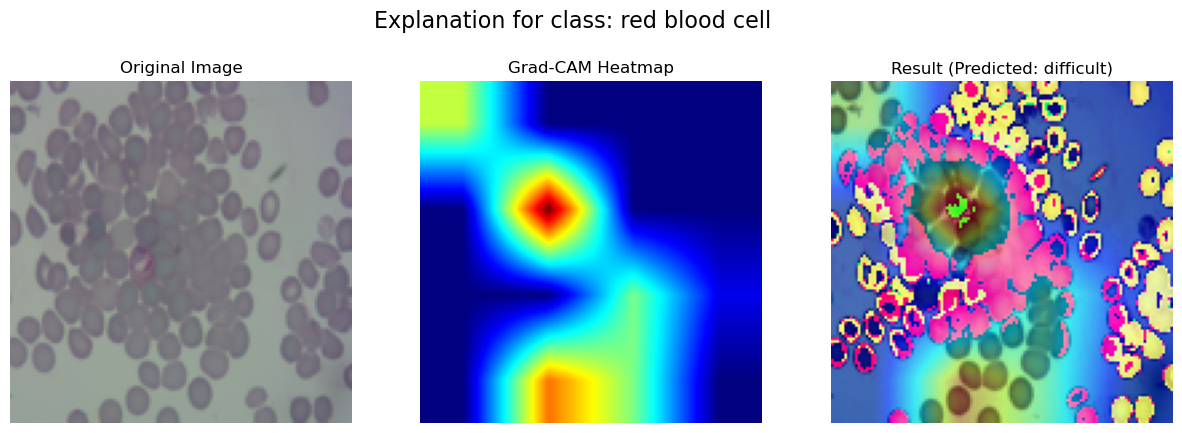

In [ ]:
# === Step 1: Load your trained EfficientNet model ===
# NOTE: You will need to save your EfficientNet models after training them.
# I'll use a placeholder filename here.
effnet_model_path = "efficientnet_b0_model.pth" # <-- IMPORTANT: Replace with your saved B0 model file
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the original model
original_model_b0 = EfficientNetDetector('b0', num_classes=len(train_ds.category_map))
# original_model_b0.load_state_dict(torch.load(effnet_model_path, map_location=device)) # Uncomment when you have a saved model
original_model_b0.to(device)


# === Step 2: Wrap the model for Grad-CAM ===
# We reuse the same wrapper class as before
gradcam_model_b0 = GradCAMModelWrapper(original_model_b0)


# === Step 3: Define the target layer for EfficientNet ===
target_layer_b0 = original_model_b0.features[-1]


# === Step 4: Get a sample image ===
test_ds_vis = MalariaDataset(test_json_path, image_path, transform=test_transform, category_map=train_ds.category_map)
image, target = test_ds_vis[25] # Pick a different index for variety


# === Step 5: Call the visualization function ===
# We use the same function, just with the new model and layer
visualize_gradcam(gradcam_model_b0, target_layer_b0, image, target_category=target['labels'][0].item())

In [ ]:
def compare_gradcam_visualizations(
    model1, target_layer1, model1_name,
    model2, target_layer2, model2_name,
    image_tensor,
    target_category=None
):
    """
    Generates and displays a side-by-side Grad-CAM comparison for two models on the same image.
    (Corrected to pass the image tensor to the cam object)
    """
    # --- Prepare necessary components ---
    image_for_model = image_tensor.to(device).unsqueeze(0)
    inv_category_map = {v: k for k, v in train_ds.category_map.items()}

    # --- Generate Grad-CAM for Model 1 ---
    cam1 = GradCAM(model1, target_layer1)
    # CORRECTED: The first argument to cam1() MUST be the image tensor.
    mask1, _ = cam1(image_for_model, target_category)
    _, result1 = visualize_cam(mask1, image_tensor)
    model1.eval()
    pred_label1 = inv_category_map.get(model1(image_for_model).argmax(dim=1).item(), "Unknown")

    # --- Generate Grad-CAM for Model 2 ---
    cam2 = GradCAM(model2, target_layer2)
    # CORRECTED: The first argument to cam2() MUST be the image tensor.
    mask2, _ = cam2(image_for_model, target_category)
    _, result2 = visualize_cam(mask2, image_tensor)
    model2.eval()
    pred_label2 = inv_category_map.get(model2(image_for_model).argmax(dim=1).item(), "Unknown")

    # --- Display the results in a 2x2 grid ---
    pil_image = to_pil_image(denormalize(image_tensor.clone()))
    result1_pil = to_pil_image(result1)
    result2_pil = to_pil_image(result2)
    target_label = inv_category_map.get(target_category, "Unknown")
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle(f"Grad-CAM Comparison for class: '{target_label}'", fontsize=20)

    # Row 1: Model 1 Results
    axs[0, 0].imshow(pil_image)
    axs[0, 0].set_title('Original Image')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(result1_pil)
    axs[0, 1].set_title(f'{model1_name} Result (Predicted: {pred_label1})')
    axs[0, 1].axis('off')
    
    # Row 2: Model 2 Results
    axs[1, 0].imshow(pil_image)
    axs[1, 0].set_title('Original Image')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(result2_pil)
    axs[1, 1].set_title(f'{model2_name} Result (Predicted: {pred_label2})')
    axs[1, 1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

C:\Users\shera\AppData\Local\Temp\ipykernel_2916\1664677091.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_model_b0.load_state_dict(torch.load("efficientnet_b

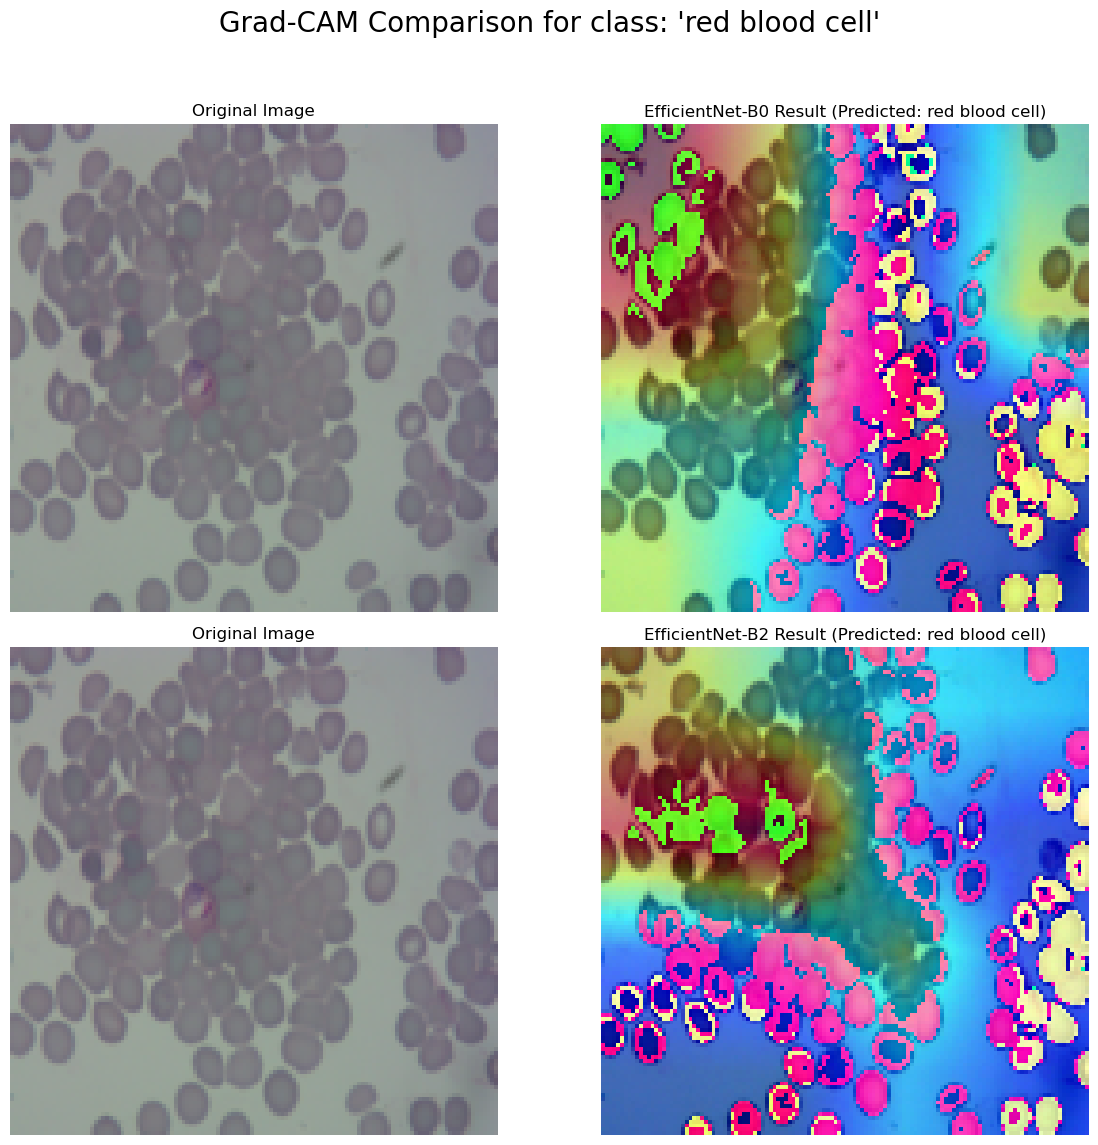

In [ ]:
# Make sure the wrapper class is defined in your notebook
class GradCAMModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        class_scores, _ = self.model(x)
        return class_scores

# === Step 1: Load BOTH trained EfficientNet models ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load B0 model
original_model_b0 = EfficientNetDetector('b0', num_classes=len(train_ds.category_map))
original_model_b0.load_state_dict(torch.load("efficientnet_b0_model.pth", map_location=device))
original_model_b0.to(device)
gradcam_model_b0 = GradCAMModelWrapper(original_model_b0)
target_layer_b0 = original_model_b0.features[-1]

# Load B2 model
original_model_b2 = EfficientNetDetector('b2', num_classes=len(train_ds.category_map))
original_model_b2.load_state_dict(torch.load("efficientnet_b2_model.pth", map_location=device))
original_model_b2.to(device)
gradcam_model_b2 = GradCAMModelWrapper(original_model_b2)
target_layer_b2 = original_model_b2.features[-1]


# === Step 2: Get a SINGLE sample image to compare on ===
test_ds_vis = MalariaDataset(test_json_path, image_path, transform=test_transform, category_map=train_ds.category_map)
image, target = test_ds_vis[25] # We will use this same image for both models
target_cat = target['labels'][0].item()


# === Step 3: Call the NEW comparison function ===
compare_gradcam_visualizations(
    model1=gradcam_model_b0, target_layer1=target_layer_b0, model1_name="EfficientNet-B0",
    model2=gradcam_model_b2, target_layer2=target_layer_b2, model2_name="EfficientNet-B2",
    image_tensor=image,
    target_category=target_cat
)

### Lime

In [ ]:
# 1. Create a LIME explainer for tabular data (same as before)
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=[f'HOG_{i}' for i in range(X_train.shape[1])],
    class_names=le.classes_,
    discretize_continuous=True
)

# 2. Pick an instance to explain (same as before)
instance_idx = 10
instance_to_explain = X_test[instance_idx]

# 3. Generate the explanation for the Random Forest model
print("--- LIME Explanation for Random Forest ---")
lime_exp_rf = lime_explainer.explain_instance(
    instance_to_explain,
    rf_model.predict_proba,
    num_features=10
)
# CORRECTED: Generate HTML and display it manually
display(HTML(lime_exp_rf.as_html()))


# 4. Generate the explanation for the SVM model
print("\n--- LIME Explanation for SVM ---")
lime_exp_svm = lime_explainer.explain_instance(
    instance_to_explain,
    lambda x: svm_model.predict_proba(scaler.transform(x)),
    num_features=10
)
# CORRECTED: Generate HTML and display it manually
display(HTML(lime_exp_svm.as_html()))

--- LIME Explanation for Random Forest ---



--- LIME Explanation for SVM ---


### SHap

--- SHAP for Random Forest ---


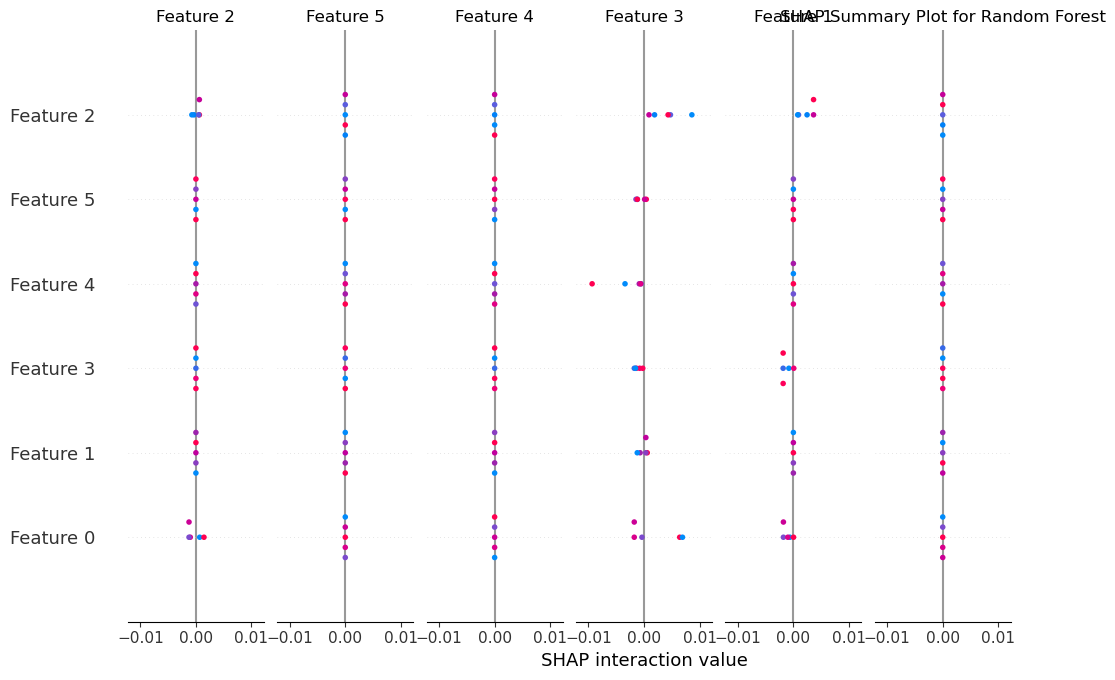


--- SHAP for SVM ---


100%|██████████| 1/1 [00:40<00:00, 40.41s/it]


Model Predicted Class: 'red blood cell'
NOTE: SHAP KernelExplainer returned an explanation for only one class.
Displaying waterfall plot for Class Index 0: 'difficult'


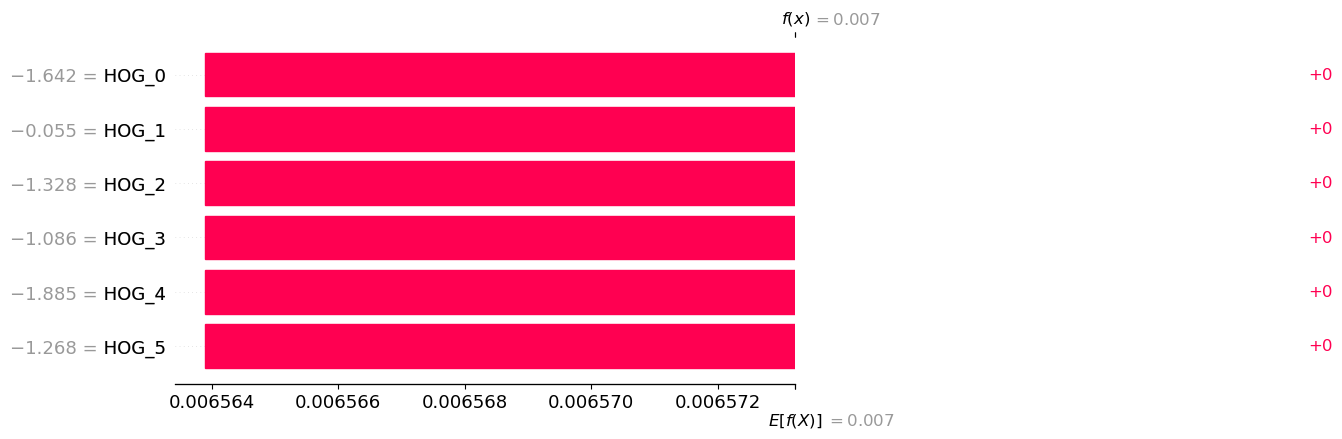

In [ ]:
import shap

# Initialize JavaScript visualization in the notebook
shap.initjs()

# --- Explain the Random Forest Model (using the faster TreeExplainer) ---
print("--- SHAP for Random Forest ---")
# Create the explainer
rf_explainer = shap.TreeExplainer(rf_model)
# Calculate SHAP values for a few test samples
shap_values_rf = rf_explainer.shap_values(X_test[:5])

# CORRECTED: Use the same data slice (X_test[:5]) for the features
shap.summary_plot(shap_values_rf, X_test[:5], class_names=le.classes_, show=False)
plt.title("SHAP Summary Plot for Random Forest")
plt.show()

# --- Explain the SVM Model (using KernelExplainer) ---
print("\n--- SHAP for SVM ---")

X_train_summary = shap.kmeans(X_train_scaled, 10)
svm_explainer = shap.KernelExplainer(svm_model.predict_proba, X_train_summary)

# --- Explain just one prediction ---
instance_to_explain = X_test_scaled[0:1]
shap_values_svm = svm_explainer.shap_values(instance_to_explain)
prediction = svm_model.predict(instance_to_explain)[0]

# --- CORRECTED PLOTTING LOGIC ---

# The explainer is only returning SHAP values for one class.
# We must use index 0 to access it.
shap_values_for_one_class = shap_values_svm[0]
base_value_for_one_class = svm_explainer.expected_value[0]
class_index_explained = 0 # This is the class SHAP explained

print(f"Model Predicted Class: '{le.classes_[prediction]}'")
print(f"NOTE: SHAP KernelExplainer returned an explanation for only one class.")
print(f"Displaying waterfall plot for Class Index {class_index_explained}: '{le.classes_[class_index_explained]}'")


# Create the waterfall plot for the available explanation (class 0)
feature_names = [f'HOG_{i}' for i in range(X_test_scaled.shape[1])]
shap.waterfall_plot(shap.Explanation(
    values=shap_values_for_one_class[0],
    base_values=base_value_for_one_class,
    data=instance_to_explain[0],
    feature_names=feature_names
))

# Metrics
<ol>
<li>Accuracy score
<li>Precision score
<li>Recall 
<li>F1 Score
<li>ROC-AUC
<li>Cross validatio
</ol>

In [ ]:
def get_dl_model_metrics(model, dataloader, device):
    """
    Runs inference and returns weighted precision, recall, and F1 score.
    (Corrected list comprehension logic)
    """
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for i, (images, targets) in enumerate(dataloader):
            images = images.to(device)
            wrapped_model = GradCAMModelWrapper(model)
            scores = wrapped_model(images)
            
            preds = torch.argmax(scores, dim=1).cpu()

            # --- CORRECTED LOGIC ---
            # 't' is the tensor of labels, not a dict. Check its length directly.
            has_labels_mask = [len(t) > 0 for t in targets['labels']]
            
            if any(has_labels_mask):
                filtered_preds = preds[torch.tensor(has_labels_mask)]
                
                # We need to get the first label from the original target dictionary structure
                labels = [targets['labels'][i][0].item() for i, has_label in enumerate(has_labels_mask) if has_label]
                
                all_preds.extend(filtered_preds.numpy())
                all_labels.extend(labels)

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    
    return precision, recall, f1

In [ ]:
def get_dl_model_probs(model, dataloader, device):
    """
    Runs inference and returns prediction probabilities.
    (Corrected list comprehension logic)
    """
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            wrapped_model = GradCAMModelWrapper(model)
            scores = wrapped_model(images)
            probs = F.softmax(scores, dim=1).cpu()

            # --- CORRECTED LOGIC ---
            # 't' is the tensor of labels, not a dict. Check its length directly.
            has_labels_mask = [len(t) > 0 for t in targets['labels']]
            
            if any(has_labels_mask):
                filtered_probs = probs[torch.tensor(has_labels_mask)]
                
                # Get the first label for each image that has one
                labels = [targets['labels'][i][0].item() for i, has_label in enumerate(has_labels_mask) if has_label]
                
                all_probs.extend(filtered_probs.numpy())
                all_labels.extend(labels)
                
    return np.array(all_probs), np.array(all_labels)

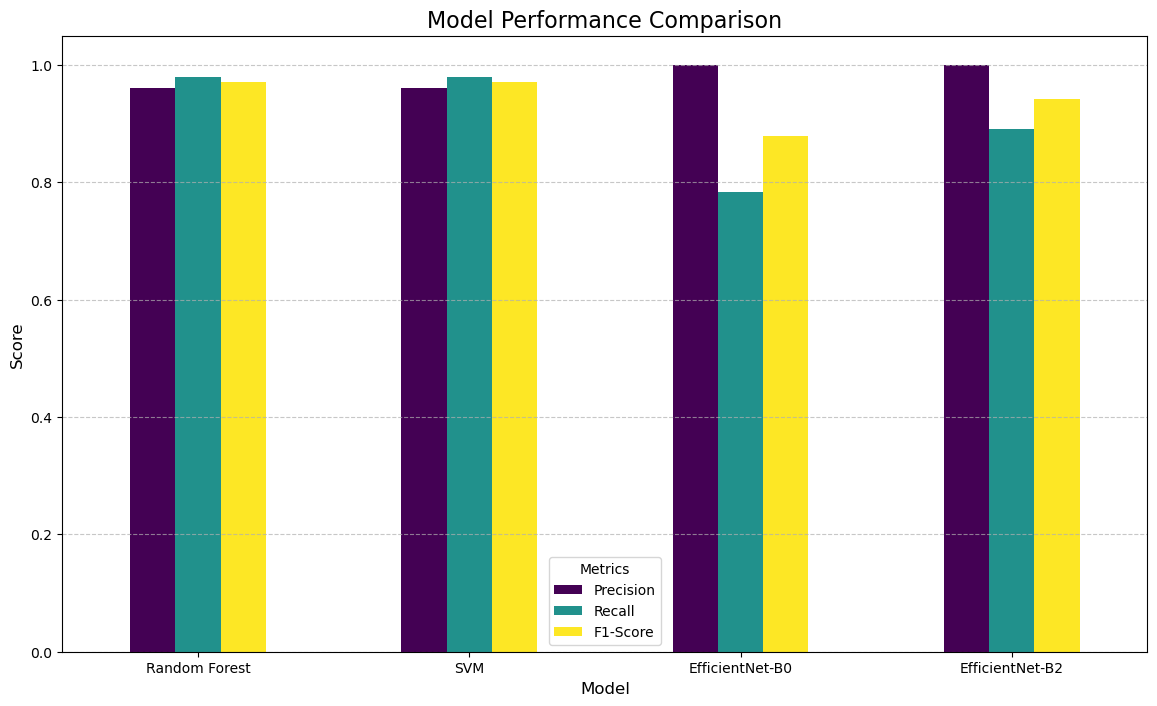

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

# --- Gather Metrics ---

# 1. Traditional Models (using the test set predictions you already have)
rf_precision, rf_recall, rf_f1, _ = precision_recall_fscore_support(y_test, rf_preds, average='weighted', zero_division=0)
svm_precision, svm_recall, svm_f1, _ = precision_recall_fscore_support(y_test, svm_preds, average='weighted', zero_division=0)

# 2. Deep Learning Models (using the new function and your trained models)
# Ensure your trained models (model_b0, model_b2) are loaded
b0_precision, b0_recall, b0_f1 = get_dl_model_metrics(model_b0, val_loader, device)
b2_precision, b2_recall, b2_f1 = get_dl_model_metrics(model_b2, val_loader, device)

# 3. Consolidate into a DataFrame for easy plotting
data = {
    'Model': ['Random Forest', 'SVM', 'EfficientNet-B0', 'EfficientNet-B2'],
    'Precision': [rf_precision, svm_precision, b0_precision, b2_precision],
    'Recall': [rf_recall, svm_recall, b0_recall, b2_recall],
    'F1-Score': [rf_f1, svm_f1, b0_f1, b2_f1]
}
df_metrics = pd.DataFrame(data).set_index('Model')

# --- Plotting ---
df_metrics.plot(kind='bar', figsize=(14, 8), colormap='viridis')
plt.title('Model Performance Comparison', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=0)
plt.ylim(0, 1.05) # Set y-axis limit to be just above 1.0
plt.legend(title='Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Skipping EfficientNet-B0 due to shape mismatch: True labels (120, 6), Probs (120, 7)
Skipping EfficientNet-B2 due to shape mismatch: True labels (120, 6), Probs (120, 7)


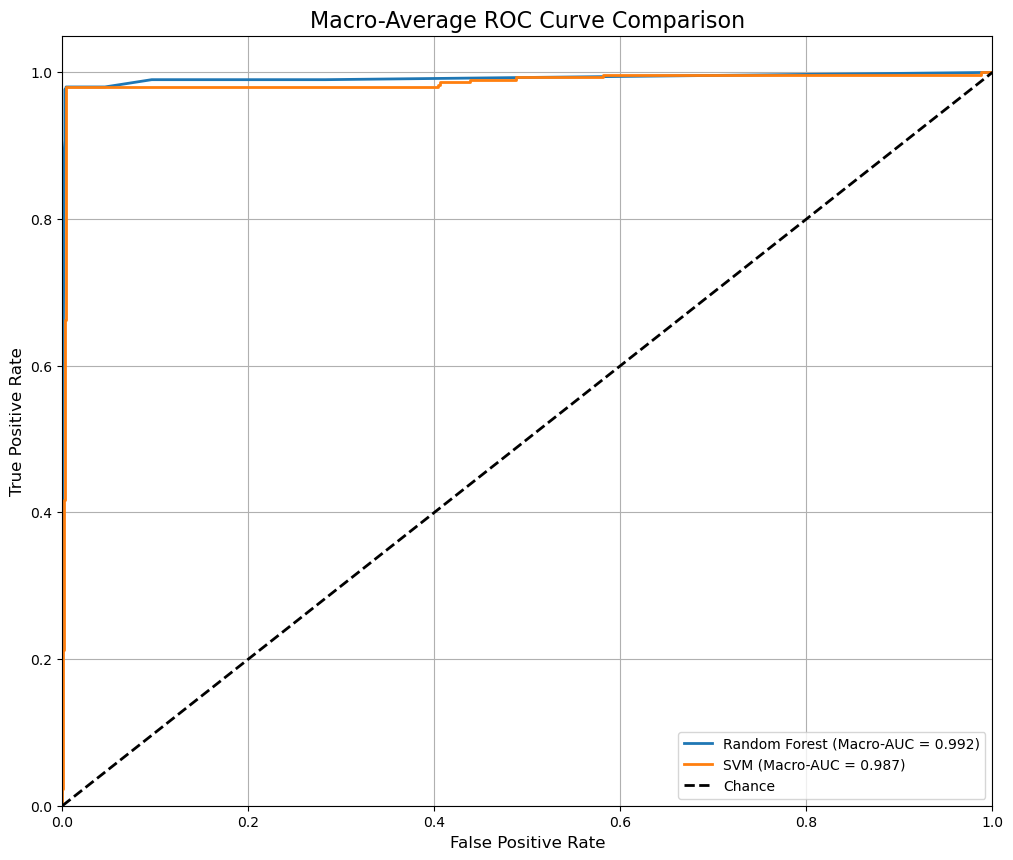

In [ ]:


# This helper function is correct from the previous step
def get_dl_model_probs(model, dataloader, device):
    """
    Runs inference and returns prediction probabilities AND their corresponding labels.
    """
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            wrapped_model = GradCAMModelWrapper(model)
            scores = wrapped_model(images)
            probs = F.softmax(scores, dim=1).cpu()
            has_labels_mask = [len(t) > 0 for t in targets['labels']]
            if any(has_labels_mask):
                filtered_probs = probs[torch.tensor(has_labels_mask)]
                labels = [targets['labels'][i][0].item() for i, has_label in enumerate(has_labels_mask) if has_label]
                all_probs.extend(filtered_probs.numpy())
                all_labels.extend(labels)
    return np.array(all_probs), np.array(all_labels)

# --- Define the number of classes consistently ---
# Use the label encoder from the traditional models as the source of truth
num_classes = len(le.classes_)

# --- Gather Probabilities and True Labels ---

# 1. Traditional Models
rf_probs = rf_model.predict_proba(X_test)
svm_probs = svm_model.predict_proba(X_test_scaled)
y_test_binarized_rf_svm = label_binarize(y_test, classes=range(num_classes))

# 2. Deep Learning Models
b0_probs, dl_labels = get_dl_model_probs(model_b0, val_loader, device)
b2_probs, _ = get_dl_model_probs(model_b2, val_loader, device)
y_test_binarized_dl = label_binarize(dl_labels, classes=range(num_classes))

# --- Plotting ROC Curves ---
plt.figure(figsize=(12, 10))

# Create a dictionary to loop through, making the code cleaner
all_model_data = {
    "Random Forest": (y_test_binarized_rf_svm, rf_probs),
    "SVM": (y_test_binarized_rf_svm, svm_probs),
    "EfficientNet-B0": (y_test_binarized_dl, b0_probs),
    "EfficientNet-B2": (y_test_binarized_dl, b2_probs)
}

for model_name, (y_true_binarized, y_probs) in all_model_data.items():
    # Verify that the shapes match before plotting
    if y_true_binarized.size != y_probs.size:
        print(f"Skipping {model_name} due to shape mismatch: True labels {y_true_binarized.shape}, Probs {y_probs.shape}")
        continue

    fpr, tpr, _ = roc_curve(y_true_binarized.ravel(), y_probs.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (Macro-AUC = {roc_auc:0.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Macro-Average ROC Curve Comparison', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# Use the full dataset (X, y_encoded) before the split
# and the unscaled features for this
X_full_scaled = scaler.fit_transform(X)


# --- 5-Fold Cross-Validation ---
# StratifiedKFold is good for imbalanced datasets
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest Cross-Validation
rf_cv_scores = cross_val_score(rf_model, X, y_encoded, cv=cv, scoring='accuracy')

# SVM Cross-Validation (use the scaled data)
svm_cv_scores = cross_val_score(svm_model, X_full_scaled, y_encoded, cv=cv, scoring='accuracy')


# --- Print Results ---
print("--- 5-Fold Cross-Validation Results ---")
print(f"Random Forest Accuracy: {rf_cv_scores.mean():.3f} (+/- {rf_cv_scores.std() * 2:.3f})")
print(f"SVM Accuracy:           {svm_cv_scores.mean():.3f} (+/- {svm_cv_scores.std() * 2:.3f})")

c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


--- 5-Fold Cross-Validation Results ---
Random Forest Accuracy: 0.982 (+/- 0.004)
SVM Accuracy:           0.982 (+/- 0.004)
